# Отчет о выполненном проекте

## Идентификация пользователей по посещенным веб-страницам

|   |   |
| --- | --- |
| Автор | Капитанов Александр |
| Дата | 21.11.2019 |
| Язык | Python 3 |

### Введение

Основная задача этого отчёта - уникальный анализ соревнования на Kaggle, поэтому весь дальнейший текст по большей части характерен для исследуемого соревнования. 

___
Я посчитал, что **нет смысла заниматься копипастом** текстов и графиков из предыдущих недель. Кроме того, этот отчёт поможет сокурсникам понять основные **ошибки** при поиске схемы для кросс-валидации к соревнованию, а также понять, почему локальные результаты не коррелировали с результатами на Leader Board соревнования Kaggle "[Catch Me If You Can](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview)".
___

```
Web-user identification is a hot research topic on the brink of sequential pattern mining and behavioral psychology.

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages. The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person) and predict whether it belongs to Alice or somebody else.

The data comes from Blaise Pascal University proxy servers. Paper "A Tool for Classification of Sequential Data" by Giacomo Kahn, Yannick Loiseau and Olivier Raynaud.
```

### Цели и задачи проекта

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. 

**В ходе выполнения проекта решается ряд задач:**
- Предобработка данных для анализа и построения моделей,
- Первичный анализ полученных данных, построение гипотез,
- Визуализация данных, построение признаков,
- Выбор модели предсказания,
- Построение кривых валидации и обучения, метрики качества обучения,
- Практическая реализация полученной модели на реальных данных (Kaggle)
- Анализ признаков для достижения лучших характеристик,
- Поиск гиперпараметров модели,
- Использование Vowpal Wabbit на примере больших массивов данных.

**Идея**: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать.

**Исходные данные**: взяты из [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf) "A Tool for Classification of Sequential Data". 

Имеются данные с прокси-серверов Университета Блеза Паскаля, они имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: <br>

<center>*timestamp, посещенный веб-сайт*</center>

**Данные:**

- Признак **site_i** – индексы посещенных сайтов,
- Признак **time_j** – время посещения сайтов,

Проверка:
- Признак **target** – 1, если сессия принадлежит Алисе (Элис), иначе 0.


 - Часть 1. Подготовка обучающей выборки
 - Часть 2. Работа с разреженным форматом данных
 
### Первичный анализ признаков

#### Весь дальнейший анализ основан для данных из соревнования Kaggle!  
Загрузим массив исходных данных и покажем, как выглядит выборка в табличном виде

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, re
import pickle
#pip install tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

**Данные разбиты на две выборки - для тестирования и для обучения**

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

TIMES = [f'time{i}' for i in range(1, 11)]
SITES = [f'site{i}' for i in range(1, 11)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id',
                       parse_dates=TIMES
                      )

test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                       index_col='session_id',
                       parse_dates=TIMES
                      )

with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    site_dict = pickle.load(f)
    
sites_dict = pd.DataFrame(data=list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

total_df = pd.concat([train_df, test_df])

train_df[SITES] = train_df[SITES].fillna(0).astype(int)
train_df.sort_values(by='time1', inplace=True)

test_df[SITES] = test_df[SITES].fillna(0).astype(int)
# test_df.sort_values(by='time1', inplace=True)

total_df[SITES] = total_df[SITES].fillna(0).astype(int)
total_df.sort_values(by='time1', inplace=True)

**Обучающая выборка**

- По сайтам:

(пропуски заполнены нулями)

In [3]:
train_df[SITES].head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947
242171,952,947,953,946,947,946,953,955,946,947
57157,953,947,946,953,955,947,953,946,953,1033
240201,946,947,954,953,946,954,946,956,957,956
210686,946,956,946,946,955,954,946,946,946,948


- По временным меткам:

In [4]:
train_df[TIMES].head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114021,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20
146670,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:20,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22


**Словарь SITE ID -> SITE NAME**

К набору данных прилагается словарь, который содержит метки ID сайтов, отображаемые на реальные названия или IP-адреса сайтов.

In [5]:
sites_dict[:10]

,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu
37491,img378.imageshack.us
5462,ecologie.nature.free.fr
35425,www.ibcn.intec.ugent.be
30151,kissanime.com
38268,www.carolineconduiteformation.com


### Первичный визуальный анализ признаков

Проведём визуализацию признаков из полученного набора данных.

Для начала отметим, что данные распределены по **времени**, следовательно разумно отобразить данные во временной шкале.

Построим график **по времени**:
- Распределение обучающей выборки,
- Распределение целевого значения (Алиса) обучающей выборки,
- Распределение тестовой выборки.

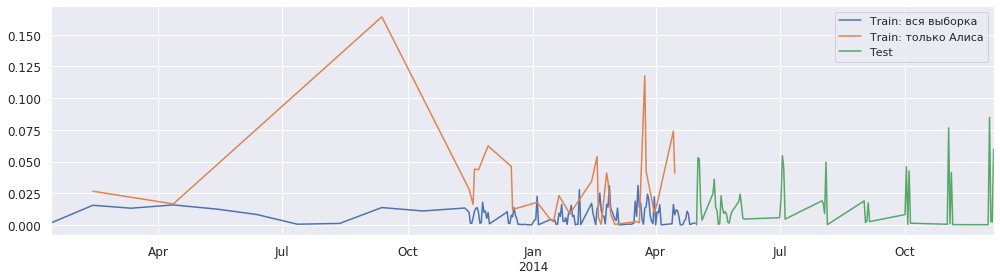

In [6]:
Xtrain, Xtest = train_df, test_df

def plot_series(df, field, label, **kwargs):
    df = df.copy()
    df['date'] = pd.DatetimeIndex(df[field]).normalize()
    df = (df['date'].value_counts()/len(df)).sort_index().resample('1D').interpolate()
    df.plot(label=label, **kwargs)

plot_series(Xtrain, 'time1', 'Train: вся выборка', figsize=(14, 4), fontsize=12)
plot_series(Xtrain[Xtrain['target']==1], 'time1', 'Train: только Алиса')
plot_series(Xtest, 'time1', 'Test')
plt.legend()
plt.tight_layout()

На графике видны пиковые области и области близкие к нулевому значению, которые можно интерпретировать как **пропуски** данных.

Посмотрим, в какие дни *года* происходит посещение веб-сайтов.

In [7]:
# Look at day of years
def convert_day(x):
    days_in_month = (31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
    for days in days_in_month:
        x -= days
        if x <= 0:
            return x+days
    return x

vectorized_conv = np.vectorize(convert_day)

Xtrain_day_of_year = Xtrain['time1'].dt.dayofyear.unique()
Xtest_day_of_year = Xtest['time1'].dt.dayofyear.unique()

vectorized_conv(Xtrain_day_of_year)

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 26, 27, 28, 31,  2,  3,  4,  5, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,
        2,  3,  4,  5, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28,  2,  3,  4,  5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [8]:
vectorized_conv(sorted(Xtest_day_of_year))

array([ 1,  2,  3,  4,  5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28,  1,  2,  4,  5,  1,  2,  3,  4,  5,  1,  2,  3,  4,
        5,  1,  2,  3,  4,  5,  1,  2,  3,  4,  5,  1,  2,  3,  4,  5,  1,
        2,  3,  4,  5])

**Можно заметить, что первые значения дней равны 12! Это подозрительно. Продолжим анализ временного массива:**

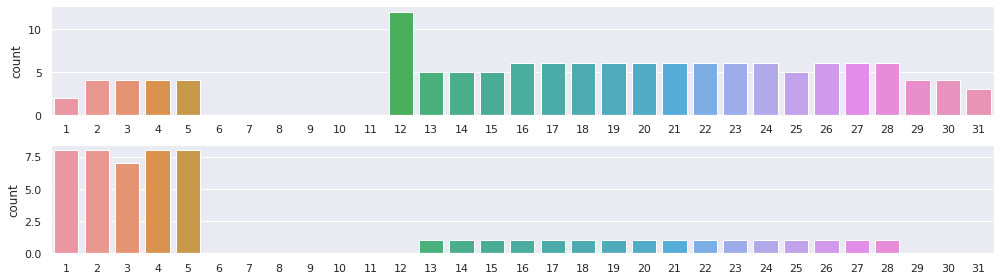

In [9]:
plt.figure('Day of month', figsize=(14, 4))
plt.subplot(2, 1, 1)
sns.countplot(vectorized_conv(Xtrain_day_of_year), order=range(1, 32))
plt.subplot(2, 1, 2)
sns.countplot(vectorized_conv(Xtest_day_of_year), order=range(1, 32))
plt.tight_layout()

### Построение графиков  распределения активности по каждому месяцу выборки

[1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[1, 2, 3, 4, 5]


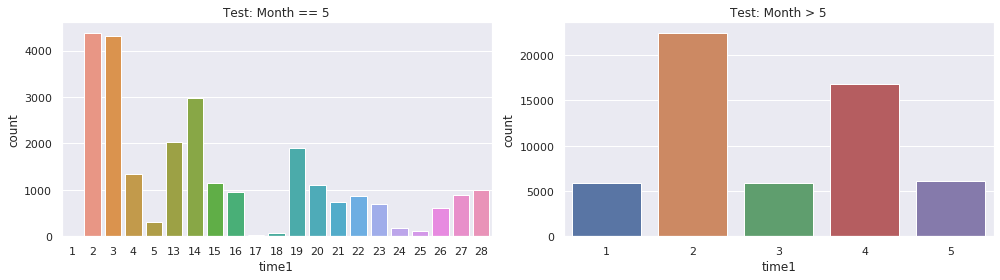

In [10]:
plt.figure('Day of month', figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('Test: Month == 5')
sns.countplot(Xtest[Xtest['time1'].dt.month == 5]['time1'].dt.day)

plt.subplot(1, 2, 2)
plt.title('Test: Month > 5')
sns.countplot(Xtest[Xtest['time1'].dt.month > 5]['time1'].dt.day)
plt.tight_layout()

print(sorted(Xtest[Xtest['time1'].dt.month == 5]['time1'].dt.day.unique()))
print(sorted(Xtest[Xtest['time1'].dt.month > 5]['time1'].dt.day.unique()))

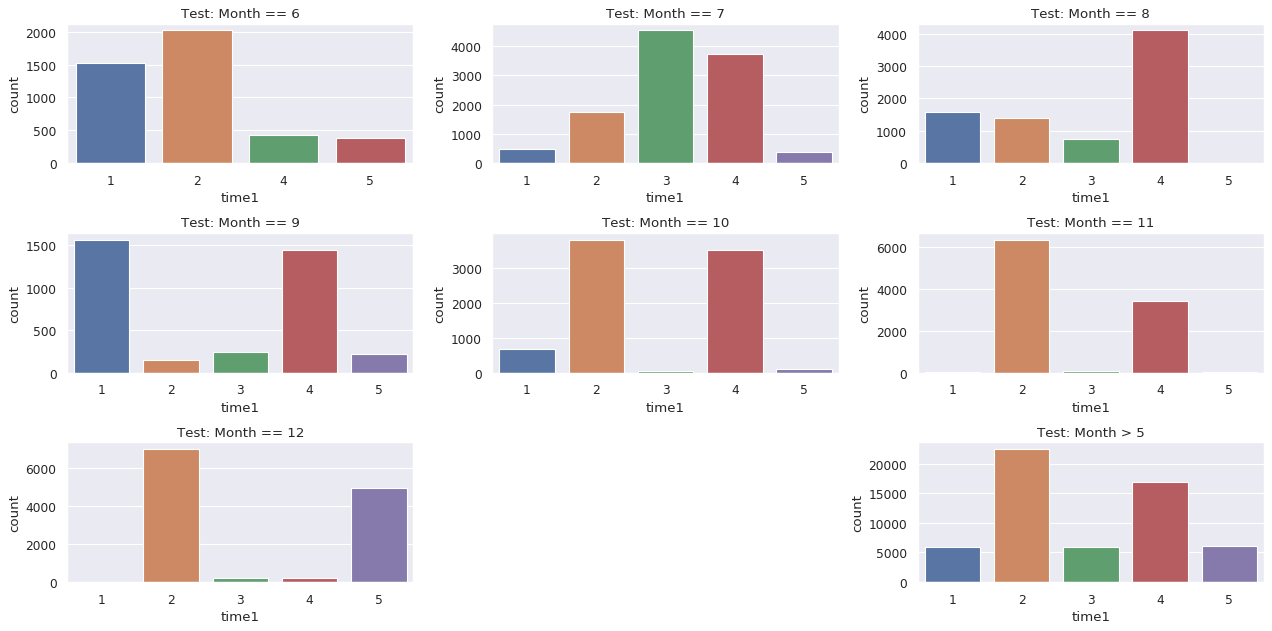

In [11]:
plt.figure('Day of month', figsize=(16, 8), dpi=80)

plt.subplot(3, 3, 1)
plt.title('Test: Month == 6')
sns.countplot(Xtest[Xtest['time1'].dt.month == 6]['time1'].dt.day)

plt.subplot(3, 3, 2)
plt.title('Test: Month == 7')
sns.countplot(Xtest[Xtest['time1'].dt.month == 7]['time1'].dt.day)

plt.subplot(3, 3, 3)
plt.title('Test: Month == 8')
sns.countplot(Xtest[Xtest['time1'].dt.month == 8]['time1'].dt.day)

plt.subplot(3, 3, 4)
plt.title('Test: Month == 9')
sns.countplot(Xtest[Xtest['time1'].dt.month == 9]['time1'].dt.day)

plt.subplot(3, 3, 5)
plt.title('Test: Month == 10')
sns.countplot(Xtest[Xtest['time1'].dt.month == 10]['time1'].dt.day)

plt.subplot(3, 3, 6)
plt.title('Test: Month == 11')
sns.countplot(Xtest[Xtest['time1'].dt.month == 11]['time1'].dt.day)

plt.subplot(3, 3, 7)
plt.title('Test: Month == 12')
sns.countplot(Xtest[Xtest['time1'].dt.month == 12]['time1'].dt.day)

plt.subplot(3, 3, 9)
plt.title('Test: Month > 5')
sns.countplot(Xtest[Xtest['time1'].dt.month > 5]['time1'].dt.day)

plt.tight_layout()

In [12]:
print(sorted(Xtest[(Xtest['time1'].dt.month == 6)]['time1'].dt.day.unique()))
print(sorted(Xtest[(Xtest['time1'].dt.month == 7)]['time1'].dt.day.unique()))
print(sorted(Xtest[(Xtest['time1'].dt.month == 8)]['time1'].dt.day.unique()))
print(sorted(Xtest[(Xtest['time1'].dt.month == 9)]['time1'].dt.day.unique()))
print(sorted(Xtest[(Xtest['time1'].dt.month == 10)]['time1'].dt.day.unique()))
print(sorted(Xtest[(Xtest['time1'].dt.month == 11)]['time1'].dt.day.unique()))
print(sorted(Xtest[(Xtest['time1'].dt.month == 12)]['time1'].dt.day.unique()))

[1, 2, 4, 5]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]


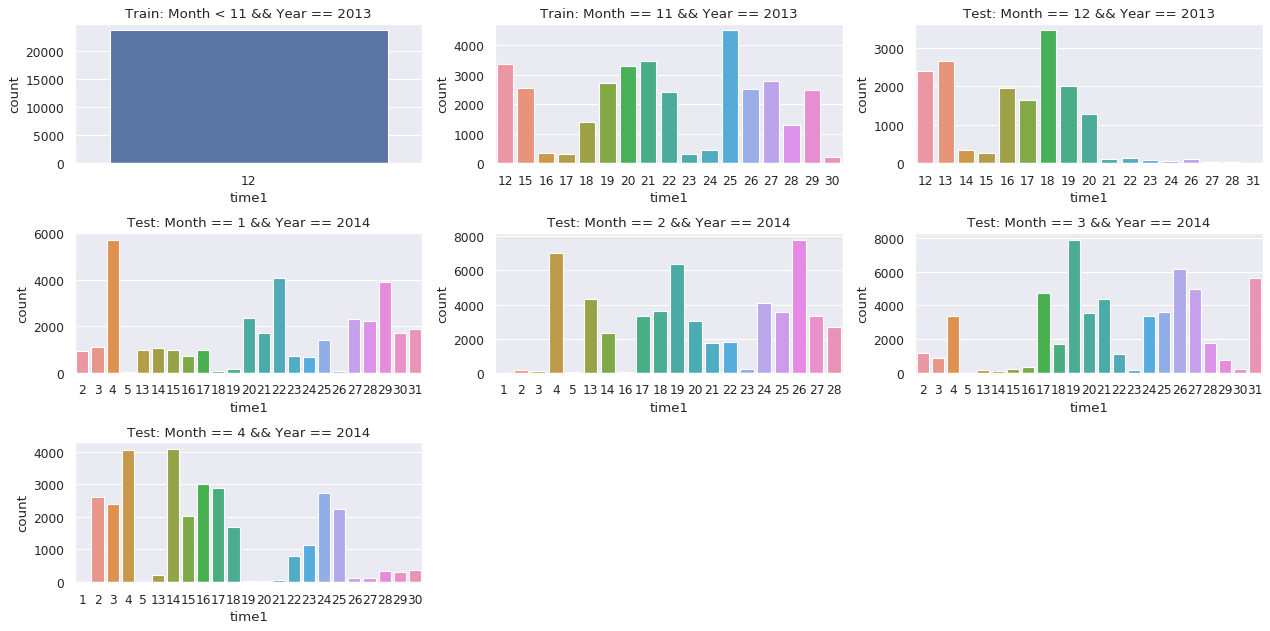

In [13]:
plt.figure('Day of month', figsize=(16, 8), dpi=80)

plt.subplot(3, 3, 1)
plt.title('Train: Month < 11 && Year == 2013')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month < 11) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day)

plt.subplot(3, 3, 2)
plt.title('Train: Month == 11 && Year == 2013')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 11) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day)

plt.subplot(3, 3, 3)
plt.title('Test: Month == 12 && Year == 2013')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 12) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day)

plt.subplot(3, 3, 4)
plt.title('Test: Month == 1 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 1) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(3, 3, 5)
plt.title('Test: Month == 2 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 2) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(3, 3, 6)
plt.title('Test: Month == 3 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 3) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(3, 3, 7)
plt.title('Test: Month == 4 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 4) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.tight_layout()

In [14]:
print(sorted(Xtrain[(Xtrain['time1'].dt.month < 11) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day.unique()))
print(sorted(Xtrain[(Xtrain['time1'].dt.month == 11) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day.unique()))
print(sorted(Xtrain[(Xtrain['time1'].dt.month == 12) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day.unique()))
print(sorted(Xtrain[(Xtrain['time1'].dt.month == 1) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day.unique()))
print(sorted(Xtrain[(Xtrain['time1'].dt.month == 2) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day.unique()))
print(sorted(Xtrain[(Xtrain['time1'].dt.month == 3) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day.unique()))
print(sorted(Xtrain[(Xtrain['time1'].dt.month == 4) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day.unique()))

[12]
[12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31]
[2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[1, 2, 3, 4, 5, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


### Распределение "дней" в каждом "месяце":

**Тестовая выборка**
- Если месяц == 5, то дни распределены от 1 до 28.
- Если месяц > 5 (от 6 до 12), то дни распределены от 1 до 5.

**Обучающая выборка**
- Если месяц < 11 в 2013 году, то день всегда = 12.
- Если месяц > 12, то дни распределены от 1 до 5, и от 6 до 30-31.

**Выводы:**
- Месяц и день необходимо поменять местами при условии `day < 12`.

### Имеем дело с ошибкой парсера!

Исправим данные в соответствии со здравым смыслом:

In [15]:
def fix_incorrect_date_formats(df, columns_to_fix):
    ndf = df.copy()
    for time in columns_to_fix:
        d = ndf[time]
        d_fix = d[d.dt.day <= 12]
        d_fix = pd.to_datetime(d_fix.apply(str), format='%Y-%d-%m %H:%M:%S')
        ndf.loc[d_fix.index.values, time] = d_fix
    return ndf

Xtrain = fix_incorrect_date_formats(Xtrain, TIMES)
Xtest = fix_incorrect_date_formats(Xtest, TIMES)

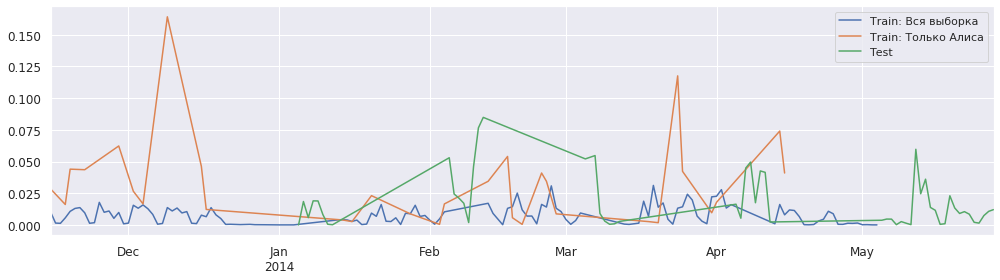

In [16]:
Xtrain.sort_values(by='time1', inplace=True)

def plot_series(df, field, label, **kwargs):
    df = df.copy()
    df['date'] = pd.DatetimeIndex(df[field]).normalize()
    df = (df['date'].value_counts()/len(df)).sort_index().resample('1D').interpolate()
    df.plot(label=label, **kwargs)

plot_series(Xtrain, 'time1', 'Train: Вся выборка', figsize=(14, 4), fontsize=12)
plot_series(Xtrain[Xtrain['target']==1], 'time1', 'Train: Только Алиса')
plot_series(Xtest, 'time1', 'Test')
plt.legend()
plt.tight_layout()

**Распределение объединенной выборки (датасета)**

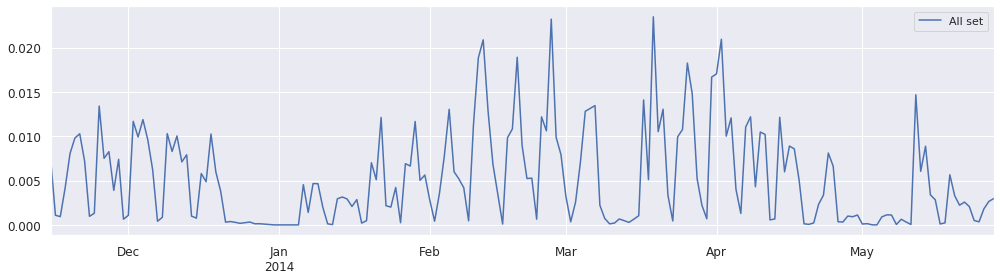

In [17]:
merged_df = pd.DataFrame(np.vstack([Xtrain[TIMES], Xtest[TIMES]]), columns=TIMES)

plot_series(merged_df, 'time1', 'All set', figsize=(14, 4), fontsize=12)
plt.legend()
plt.tight_layout()

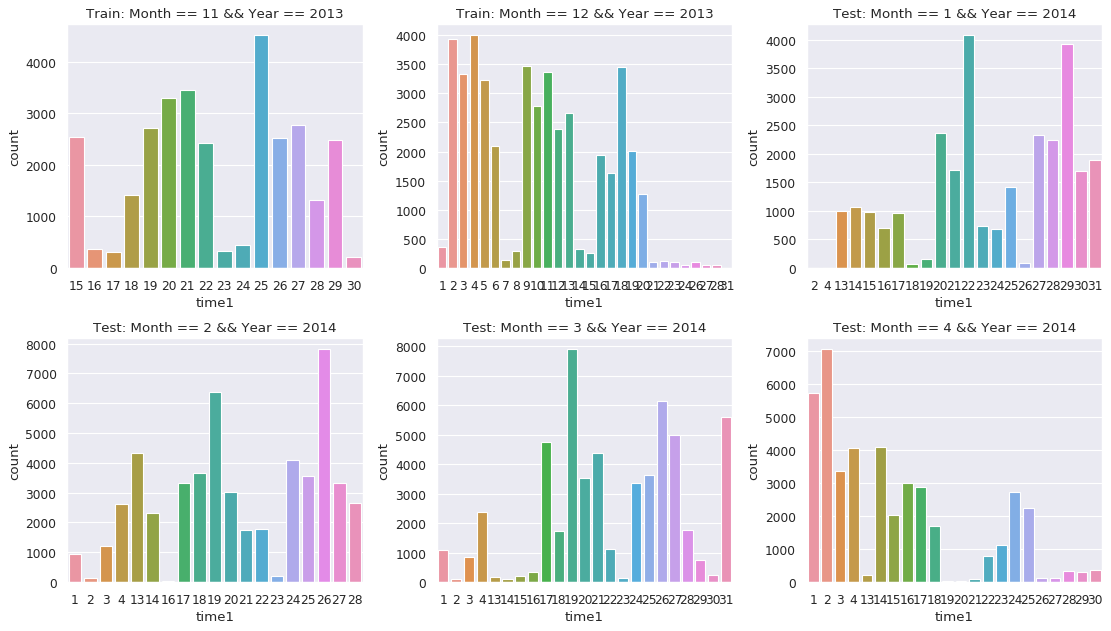

In [18]:
plt.figure('Day of month', figsize=(14, 8), dpi=80)

plt.subplot(2, 3, 1)
plt.title('Train: Month == 11 && Year == 2013')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 11) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day)

plt.subplot(2, 3, 2)
plt.title('Train: Month == 12 && Year == 2013')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 12) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day)

plt.subplot(2, 3, 3)
plt.title('Test: Month == 1 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 1) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(2, 3, 4)
plt.title('Test: Month == 2 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 2) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(2, 3, 5)
plt.title('Test: Month == 3 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 3) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(2, 3, 6)
plt.title('Test: Month == 4 && Year == 2014')
sns.countplot(Xtrain[(Xtrain['time1'].dt.month == 4) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.tight_layout()

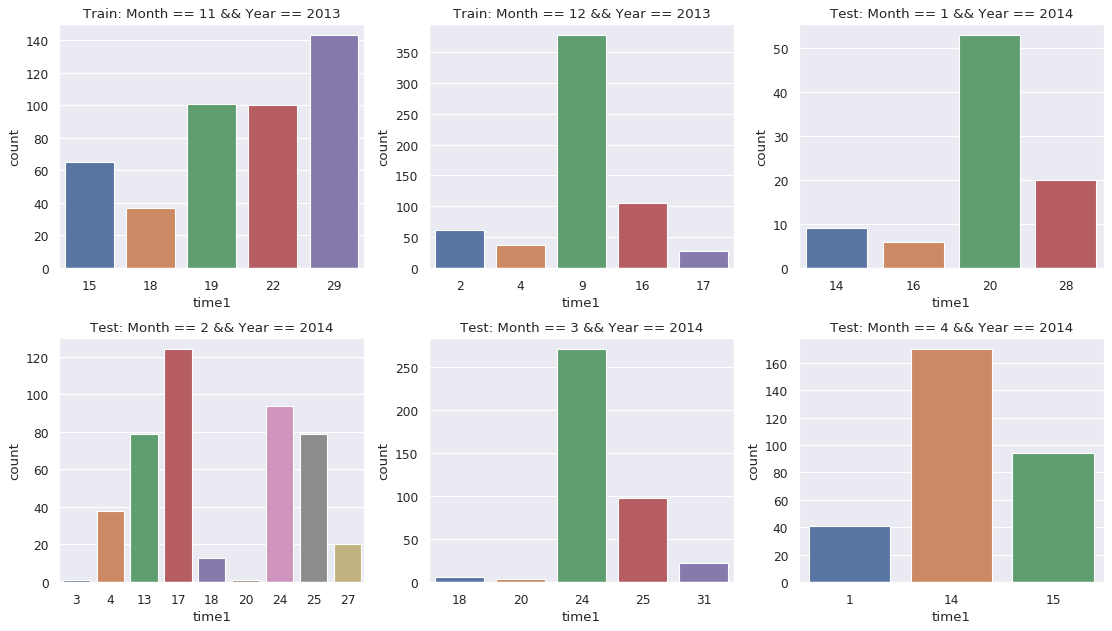

In [19]:
plt.figure('Day of month', figsize=(14, 8), dpi=80)

plt.subplot(2, 3, 1)
plt.title('Train: Month == 11 && Year == 2013')
sns.countplot(Xtrain[Xtrain.target == 1][(Xtrain['time1'].dt.month == 11) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day)

plt.subplot(2, 3, 2)
plt.title('Train: Month == 12 && Year == 2013')
sns.countplot(Xtrain[Xtrain.target == 1][(Xtrain['time1'].dt.month == 12) & (Xtrain['time1'].dt.year == 2013)]['time1'].dt.day)

plt.subplot(2, 3, 3)
plt.title('Test: Month == 1 && Year == 2014')
sns.countplot(Xtrain[Xtrain.target == 1][(Xtrain['time1'].dt.month == 1) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(2, 3, 4)
plt.title('Test: Month == 2 && Year == 2014')
sns.countplot(Xtrain[Xtrain.target == 1][(Xtrain['time1'].dt.month == 2) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(2, 3, 5)
plt.title('Test: Month == 3 && Year == 2014')
sns.countplot(Xtrain[Xtrain.target == 1][(Xtrain['time1'].dt.month == 3) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.subplot(2, 3, 6)
plt.title('Test: Month == 4 && Year == 2014')
sns.countplot(Xtrain[Xtrain.target == 1][(Xtrain['time1'].dt.month == 4) & (Xtrain['time1'].dt.year == 2014)]['time1'].dt.day)

plt.tight_layout()

**Можно заметить, что Алиса посещает сайты только в редкие дни месяца. Отметим этот факт для дальнейшего анализа при построении модели**

In [20]:
print(sorted(Xtrain[Xtrain['time1'].dt.month == 11][Xtrain.target == 1]['time1'].dt.day.unique()))
print(sorted(Xtrain[Xtrain['time1'].dt.month == 12][Xtrain.target == 1]['time1'].dt.day.unique()))
print(sorted(Xtrain[Xtrain['time1'].dt.month == 1][Xtrain.target == 1]['time1'].dt.day.unique()))
print(sorted(Xtrain[Xtrain['time1'].dt.month == 2][Xtrain.target == 1]['time1'].dt.day.unique()))
print(sorted(Xtrain[Xtrain['time1'].dt.month == 3][Xtrain.target == 1]['time1'].dt.day.unique()))
print(sorted(Xtrain[Xtrain['time1'].dt.month == 4][Xtrain.target == 1]['time1'].dt.day.unique()))

[15, 18, 19, 22, 29]
[2, 4, 9, 16, 17]
[14, 16, 20, 28]
[3, 4, 13, 17, 18, 20, 24, 25, 27]
[18, 20, 24, 25, 31]
[1, 14, 15]


### Сбалансированная выборка

После всех преобразований получена сбалансированная по времени выборка, с которой можно работать дальше.

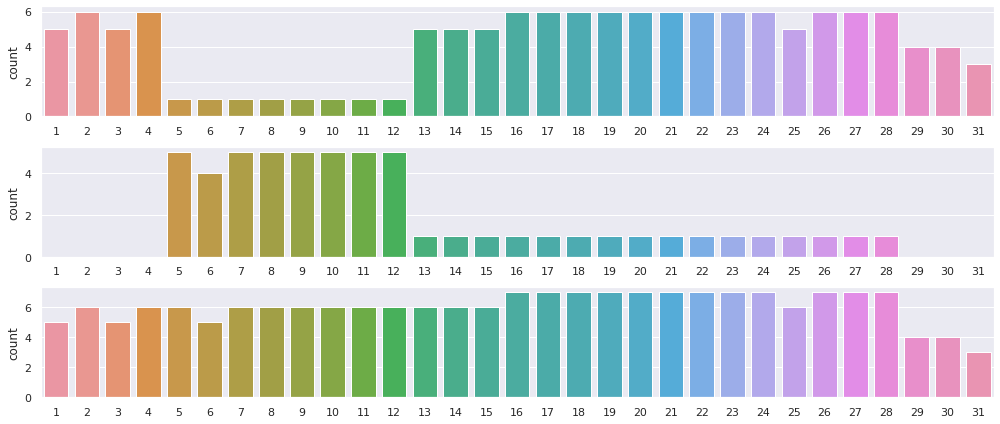

In [21]:
Xtrain_day_of_year = Xtrain['time1'].dt.dayofyear.unique()
Xtest_day_of_year = Xtest['time1'].dt.dayofyear.unique()
Xmerged_day_of_year = merged_df['time1'].dt.dayofyear.unique()

plt.figure('Day of month', figsize=(14, 6))
plt.subplot(3, 1, 1)
sns.countplot(vectorized_conv(Xtrain_day_of_year), order=range(1, 32))
plt.subplot(3, 1, 2)
sns.countplot(vectorized_conv(Xtest_day_of_year), order=range(1, 32))
plt.subplot(3, 1, 3)
sns.countplot(vectorized_conv(Xmerged_day_of_year), order=range(1, 32))
plt.tight_layout()

## Визуализация временных признаков (продолжение)

На следующем шаге проведем анализ распределения данных по различным временным признакам.

**Признаки**:
- День
- Час
- Месяц
- Месяц и год
- День недели,
- Длительность сессии
и т.д.

**Особое внимание уделим распределениям при target == 1 (сессии Алисы).**

In [22]:
Xtrain['day'] = Xtrain['time1'].dt.day.astype(np.int8)
Xtrain['hour'] = Xtrain['time1'].dt.hour.astype(np.int8)
Xtrain['month'] = Xtrain['time1'].dt.month.astype(np.int8)
Xtrain['yyyymm'] = Xtrain['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32)
Xtrain['weekday'] = Xtrain['time1'].dt.dayofweek.astype(np.int8)
Xtrain['weekyear'] = Xtrain['time1'].dt.weekofyear.astype(np.int8)
Xtrain['duration'] = (Xtrain[TIMES].max(1) - Xtrain[TIMES].min(1)).dt.seconds

Xtest['day'] = Xtest['time1'].dt.day.astype(np.int8)
Xtest['hour'] = Xtest['time1'].dt.hour.astype(np.int8)
Xtest['month'] = Xtest['time1'].dt.month.astype(np.int8)
Xtest['yyyymm'] = Xtest['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32)
Xtest['weekday'] = Xtest['time1'].dt.dayofweek.astype(np.int8)
Xtest['weekyear'] = Xtest['time1'].dt.weekofyear.astype(np.int8)
Xtest['duration'] = (Xtest[TIMES].max(1) - Xtest[TIMES].min(1)).dt.seconds


Xtrain['yymm'] = 12 * (Xtrain['time1'].dt.year - 2013) + Xtrain['time1'].dt.month
Xtest['yymm'] = 12 * (Xtest['time1'].dt.year - 2013) + Xtest['time1'].dt.month

Xtrain['mins'] = Xtrain['time1'].dt.minute.astype(np.int8)
Xtest['mins'] = Xtest['time1'].dt.minute.astype(np.int8)

## Признак: час начала сессии

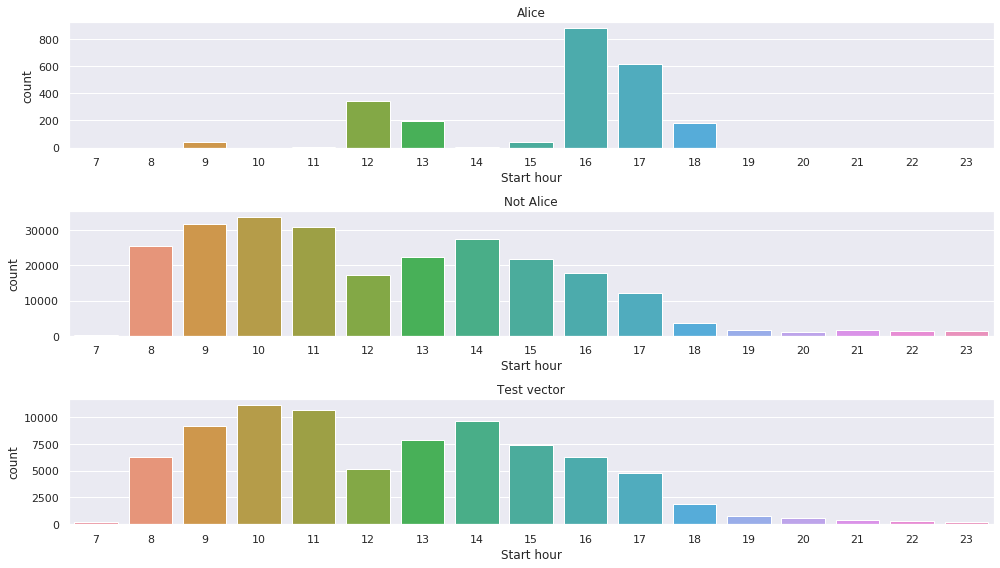

In [23]:
hour_range = sorted(list(Xtrain['hour'].unique()))

plt.figure('Hours', figsize=(14, 8))

plt.subplot(3, 1, 1)
sns.countplot(Xtrain[Xtrain.target == 1]['hour'], order=hour_range)
plt.title("Alice")
plt.xlabel('Start hour')

plt.subplot(3, 1, 2)
sns.countplot(Xtrain[Xtrain.target == 0]['hour'], order=hour_range)
plt.title("Not Alice")
plt.xlabel('Start hour')

plt.subplot(3, 1, 3)
sns.countplot(Xtest['hour'], order=hour_range)
plt.title("Test vector")
plt.tight_layout()
plt.xlabel('Start hour')
plt.tight_layout()

In [24]:
Xtrain[Xtrain.target == 1]['hour'].value_counts()

16    879
17    618
12    340
13    196
18    179
15     40
9      38
14      4
11      3
Name: hour, dtype: int64

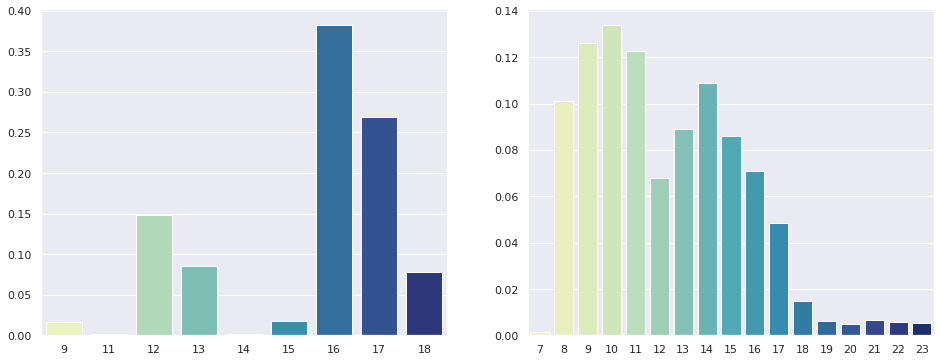

In [25]:
hours1 = Xtrain[Xtrain['target']==1]['hour'].value_counts(normalize=True)
hours0 = Xtrain[Xtrain['target']==0]['hour'].value_counts(normalize=True)
plt.figure('Hours', figsize=(16, 6))
plt.subplot(1, 2, 1)
ax = sns.barplot(hours1.index, hours1.values, palette="YlGnBu")
plt.subplot(1, 2, 2)
ax = sns.barplot(hours0.index, hours0.values, palette="YlGnBu")

## Признак: день начала сессии

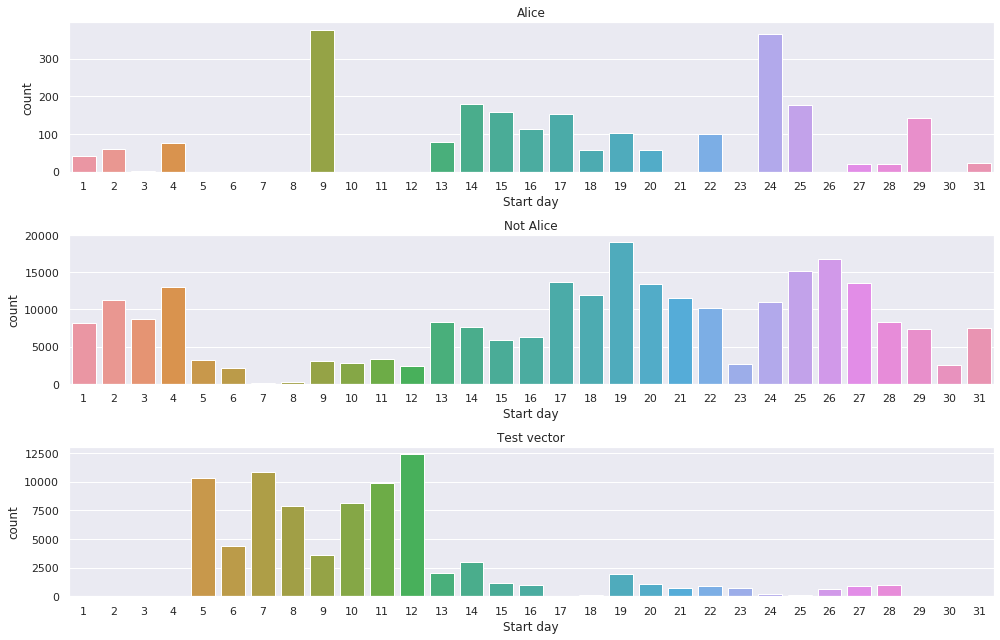

In [26]:
day_range = sorted(list(Xtrain['day'].unique()))

plt.figure('Day_of_session', figsize=(14, 9))

plt.subplot(3, 1, 1)
sns.countplot(Xtrain[Xtrain.target == 1]['day'], order=day_range)
plt.title("Alice")
plt.xlabel('Start day')

plt.subplot(3, 1, 2)
sns.countplot(Xtrain[Xtrain.target == 0]['day'], order=day_range)
plt.title("Not Alice")
plt.xlabel('Start day')

plt.subplot(3, 1, 3)
sns.countplot(Xtest['day'], order=day_range)
plt.title("Test vector")
plt.xlabel('Start day')
plt.tight_layout()

In [27]:
Xtrain[Xtrain.target == 1]['day'].value_counts()

9     377
24    364
14    179
25    176
15    159
17    152
29    143
16    112
19    101
22    100
13     79
4      76
2      61
20     58
18     56
1      41
31     22
28     20
27     20
3       1
Name: day, dtype: int64

## Признак: Неделя года

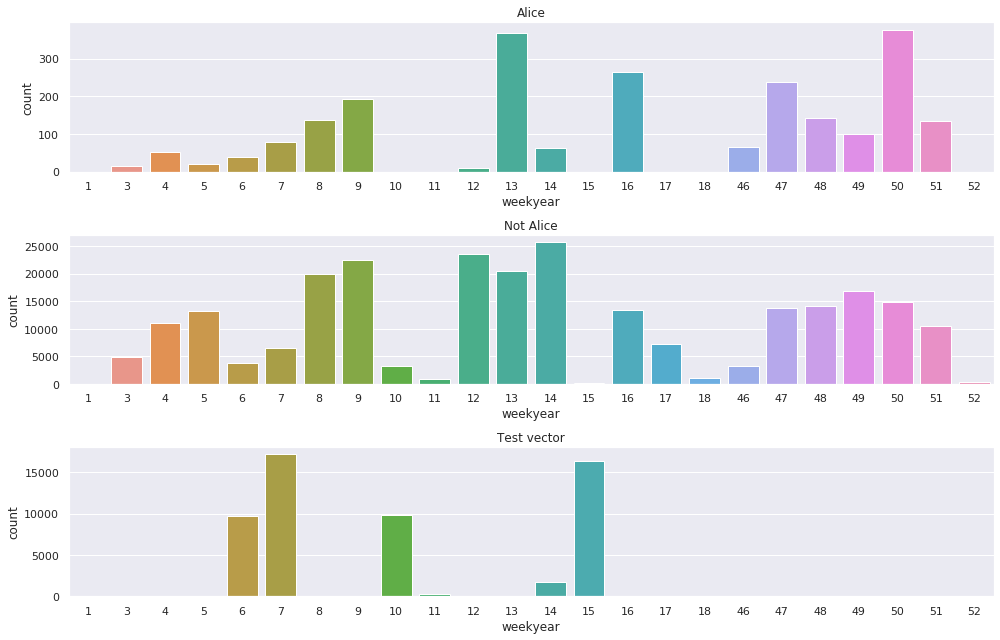

In [28]:
day_range = sorted(list(Xtrain['weekyear'].unique()))

plt.figure('Weekyear', figsize=(14, 9))

plt.subplot(3, 1, 1)
sns.countplot(Xtrain[Xtrain.target == 1]['weekyear'], order=day_range)
plt.title("Alice")

plt.subplot(3, 1, 2)
sns.countplot(Xtrain[Xtrain.target == 0]['weekyear'], order=day_range)
plt.title("Not Alice")

plt.subplot(3, 1, 3)
sns.countplot(Xtest['weekyear'], order=day_range)
plt.title("Test vector")
plt.tight_layout()

In [29]:
Xtrain[Xtrain.target == 1]['weekyear'].value_counts()

50    377
13    367
16    264
47    238
9     193
48    143
8     138
51    134
49     99
7      79
46     65
14     63
4      53
6      39
5      20
3      15
12     10
Name: weekyear, dtype: int64

## Признак: Месяц по годам

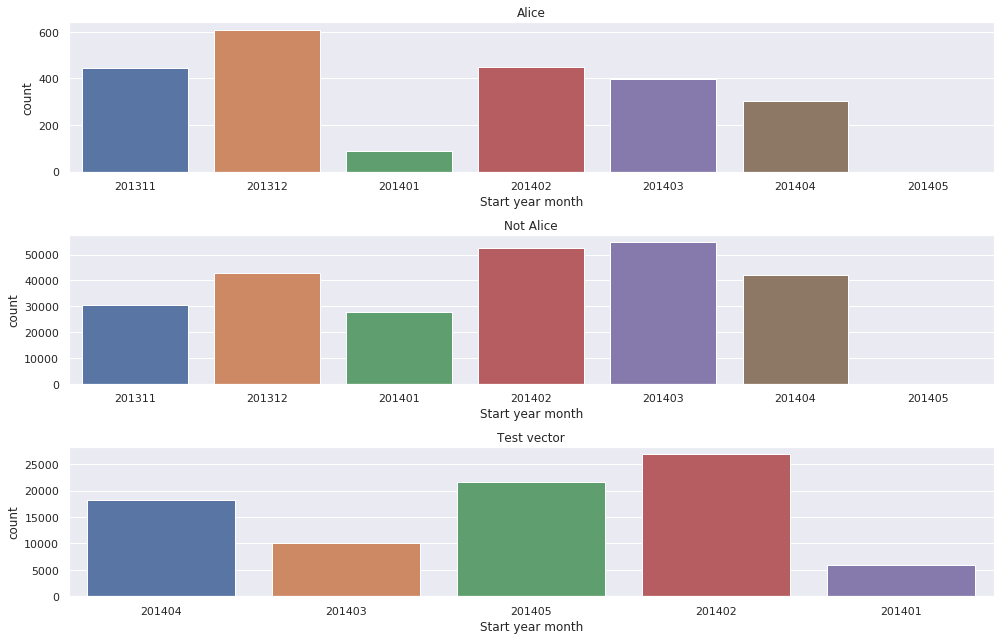

In [30]:
yyyymm_range = sorted(list(Xtrain['yyyymm'].unique())+list(Xtest['yyyymm'].unique()))
# df.apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32)
plt.subplots(1, 3, figsize=(14, 9))

plt.subplot(3, 1, 1)
sns.countplot(Xtrain[Xtrain.target == 1]['yyyymm'], order=list(Xtrain['yyyymm'].unique()))
plt.title("Alice")
plt.xlabel('Start year month')

plt.subplot(3, 1, 2)
sns.countplot(Xtrain[Xtrain.target == 0]['yyyymm'], order=list(Xtrain['yyyymm'].unique()))
plt.title("Not Alice")
plt.xlabel('Start year month')

plt.subplot(3, 1, 3)
sns.countplot(Xtest['yyyymm'], order=list(Xtest['yyyymm'].unique()))
plt.title("Test vector")
plt.xlabel('Start year month')
plt.tight_layout()

## Признак: день недели

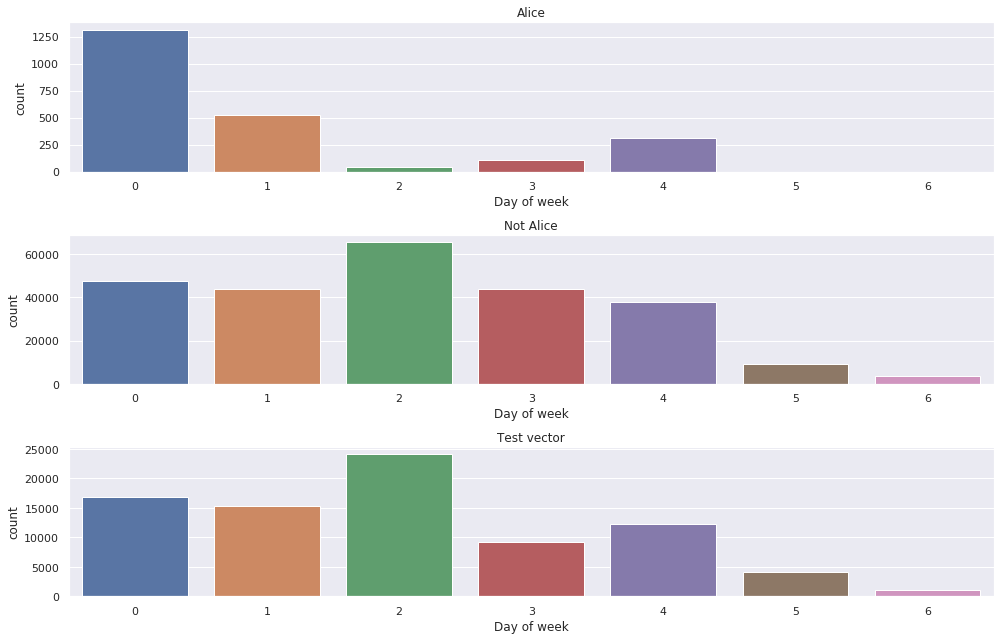

In [31]:
plt.subplots(1, 3, figsize=(14, 9))

plt.subplot(3, 1, 1)
sns.countplot(Xtrain[Xtrain.target == 1]['weekday'], order=list(range(7)))
plt.title("Alice")
plt.xlabel('Day of week')

plt.subplot(3, 1, 2)
sns.countplot(Xtrain[Xtrain.target == 0]['weekday'], order=list(range(7)))
plt.title("Not Alice")
plt.xlabel('Day of week')

plt.subplot(3, 1, 3)
sns.countplot(Xtest['weekday'], order=list(range(7)))
plt.title("Test vector")
plt.xlabel('Day of week')
plt.tight_layout()

In [32]:
print('Day of week Alice:', sorted(Xtrain[Xtrain.target == 1]['weekday'].unique()))

Xtrain[Xtrain.target == 1]['weekday'].value_counts()

Day of week Alice: [0, 1, 2, 3, 4]


0    1315
1     526
4     308
3     110
2      38
Name: weekday, dtype: int64

## Признак: месяц

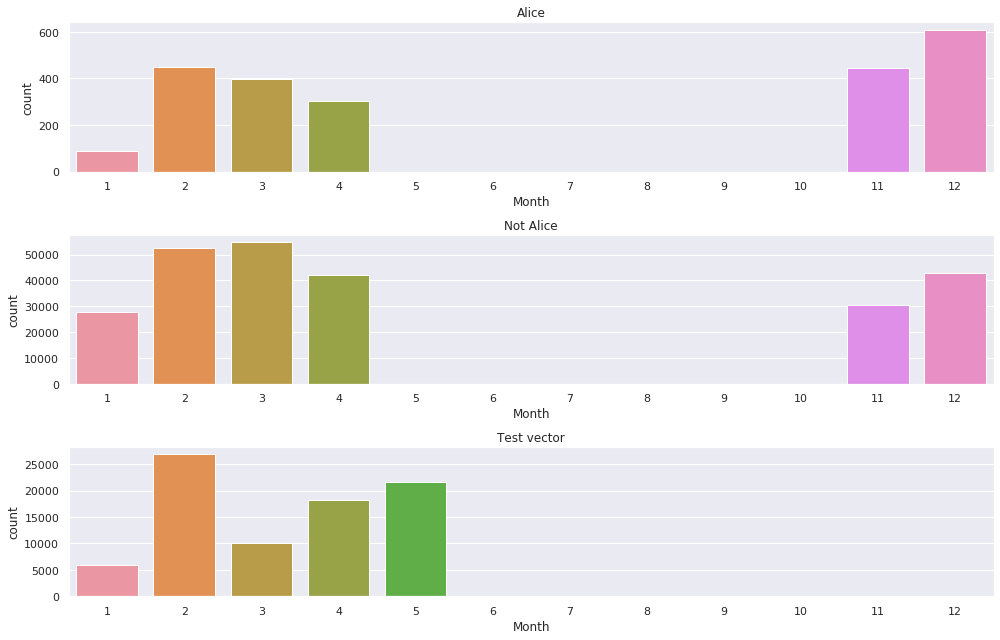

In [33]:
plt.subplots(1, 3, figsize=(14, 9))

plt.subplot(3, 1, 1)
sns.countplot(Xtrain[Xtrain.target == 1]['month'], order=list(range(1, 13)))
plt.title("Alice")
plt.xlabel('Month')

plt.subplot(3, 1, 2)
sns.countplot(Xtrain[Xtrain.target == 0]['month'], order=list(range(1, 13)))
plt.title("Not Alice")
plt.xlabel('Month')

plt.subplot(3, 1, 3)
sns.countplot(Xtest['month'], order=list(range(1, 13)))
plt.title("Test vector")
plt.xlabel('Month')
plt.tight_layout()

## Распределение комбинации признаков

Посмотрим, как связаны между собой пары признаков (например "день-час"):

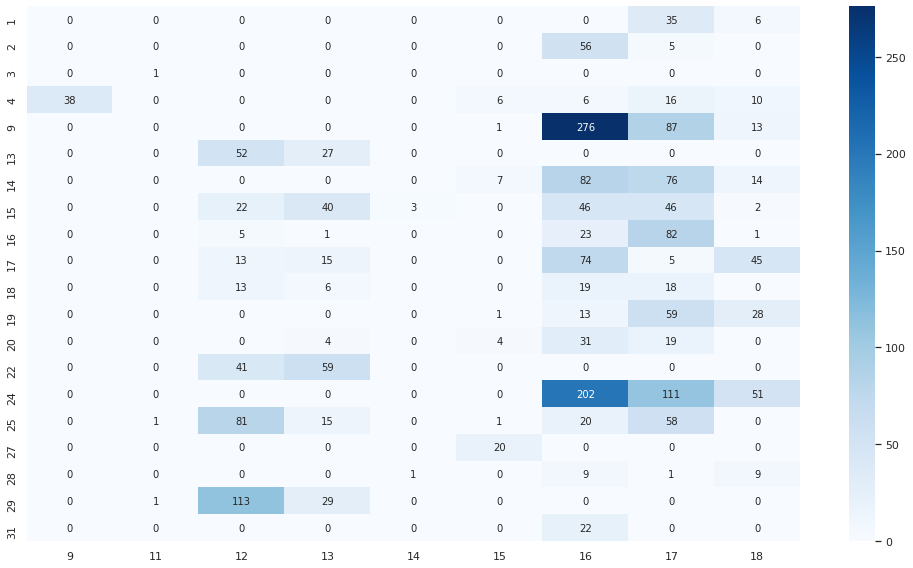

In [34]:
def alice_feat_time_compare(xtrain, feats):
    y = xtrain[xtrain.target == 1][feats]

    z = pd.DataFrame(
        index=[i for i in sorted(y[feats[0]].unique())], 
        columns=[i for i in sorted(y[feats[1]].unique())],
    )

    for i in y[feats[0]].unique():
        z.loc[i] = y[y[feats[0]] == i][feats[1]].value_counts()

    z = z.fillna(0).astype(int)

    plt.figure(figsize=(14, 8))
    sns.heatmap(z, annot=True, fmt="d", cmap='Blues')
    plt.tight_layout()
    
alice_feat_time_compare(Xtrain, ['day', 'hour'])

### Распределение пары признаков "месяц-час"

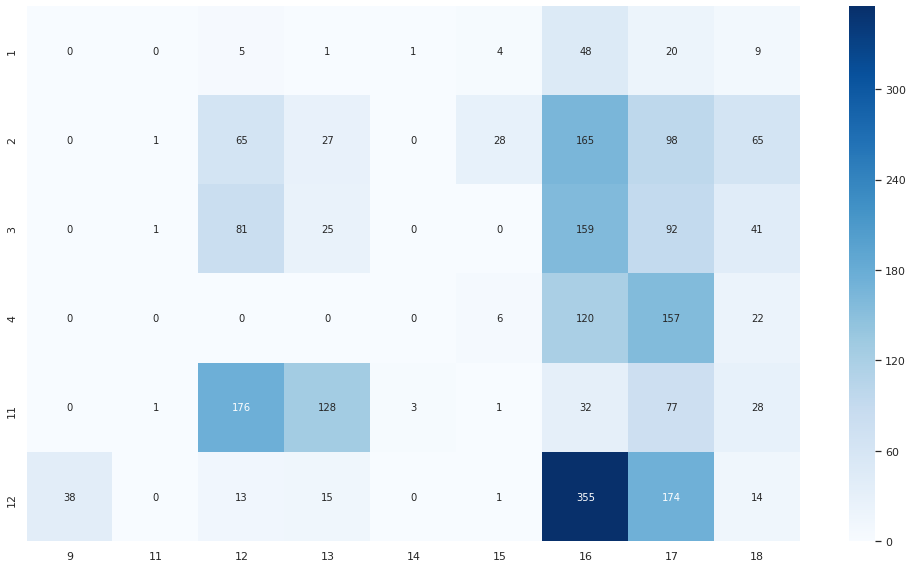

In [35]:
alice_feat_time_compare(Xtrain, ['month', 'hour'])

### Распределение пары признаков "день недели  -час"

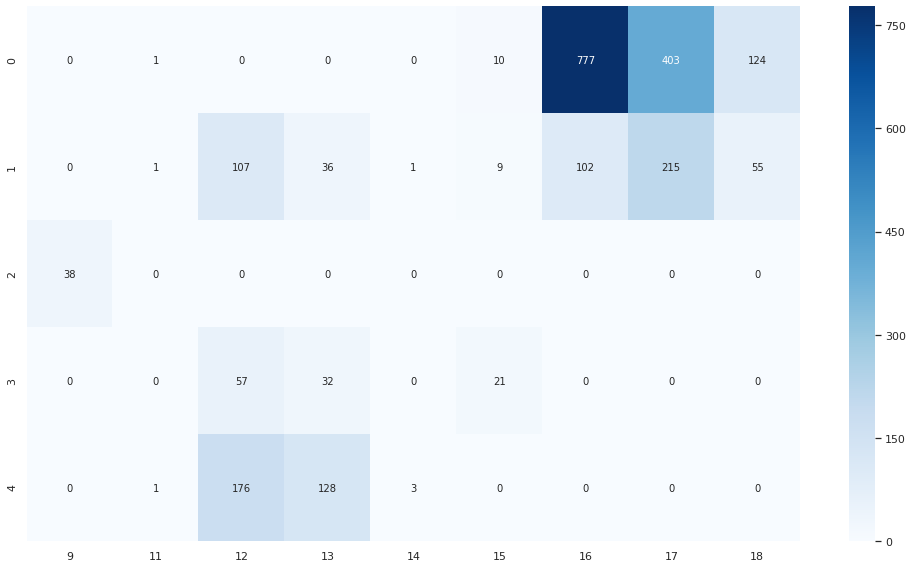

In [36]:
alice_feat_time_compare(Xtrain, ['weekday', 'hour'])

### Длительность сессии (в минутах)

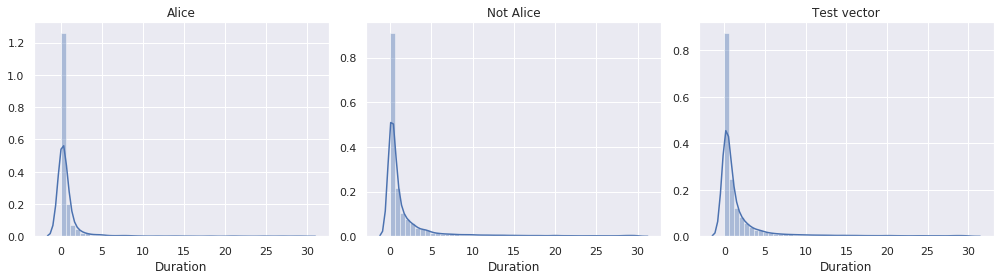

In [37]:
plt.subplots(1, 3, figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.distplot(Xtrain[Xtrain.target == 1]['duration'] / 60)
plt.title("Alice")
plt.xlabel('Duration')

plt.subplot(1, 3, 2)
sns.distplot(Xtrain[Xtrain.target == 0]['duration'] / 60)
plt.title("Not Alice")
plt.xlabel('Duration')

plt.subplot(1, 3, 3)
sns.distplot(Xtest['duration'] / 60)
plt.title("Test vector")
plt.xlabel('Duration')
plt.tight_layout()

In [38]:
Xtrain[Xtrain.target == 1]['duration'] / 60

session_id
79635      8.516667
11791      0.300000
250238     0.466667
72789      3.616667
184885     3.166667
            ...    
188473     0.383333
40139      0.216667
205622    15.683333
60720      0.783333
244233     0.033333
Name: duration, Length: 2297, dtype: float64

## Активность и топ-10 сайтов

Посмотрим на топ-10 сайтов, которые посещают пользователи, в частности, Алиса:

In [39]:
top_sites = pd.Series(Xtrain[SITES].values.flatten()).value_counts().sort_values(ascending=False)[1:11]
top_sites

0      122730
23      87619
782     77055
22      58258
29      54094
167     46405
780     43841
778     38194
52      36085
812     35178
dtype: int64

Исследовать сайты в виде ID не показательно, переведем их в реальные названия.

In [40]:
# create an inverse id _> site mapping
id2site = {v:k for (k, v) in site_dict.items()}
# we treat site with id 0 as "unknown"
id2site[0] = 'unknown'

In [74]:
# Uncomment THIS FOR TOTAL RESULT
# Xtrain[SITES] = Xtrain[SITES].fillna(0).astype(int).apply(lambda x: x.map(id2site))
# Xtest[SITES] = Xtrain[SITES].fillna(0).astype(int).apply(lambda x: x.map(id2site))

In [43]:
Xtrain[SITES].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
27554,security.debian.org,www-fourier.ujf-grenoble.fr,www-fourier.ujf-grenoble.fr,security.debian.org,backports.debian.org,backports.debian.org,www-fourier.ujf-grenoble.fr,security.debian.org,backports.debian.org,www-fourier.ujf-grenoble.fr
81350,backports.debian.org,security.debian.org,backports.debian.org,www-fourier.ujf-grenoble.fr,security.debian.org,backports.debian.org,backports.debian.org,www-fourier.ujf-grenoble.fr,security.debian.org,backports.debian.org
234665,cnfg.toolbarservices.com,www.google.com,utils.delta-search.com,ajax.googleapis.com,ajax.googleapis.com,img.babylon.com,img.babylon.com,www.google.fr,www.google.com,apis.google.com
97610,www.google.com,www.google.com,apis.google.com,www.google.fr,ieonline.microsoft.com,go.microsoft.com,javadl-esd-secure.oracle.com,img.babylon.com,img.babylon.com,javadl-esd-secure.oracle.com
161358,backports.debian.org,backports.debian.org,www-fourier.ujf-grenoble.fr,security.debian.org,backports.debian.org,unknown,unknown,unknown,unknown,unknown


In [44]:
# Alice
top_sites_1 = pd.Series(Xtrain[Xtrain.target==1][SITES].values.flatten()).value_counts().sort_values(ascending=False)[:50]
top_sites_0 = pd.Series(Xtrain[Xtrain.target==0][SITES].values.flatten()).value_counts().sort_values(ascending=False)[:50]

x1 = pd.DataFrame(top_sites_1.values, top_sites_1.index)
x0 = pd.DataFrame(top_sites_0.values, top_sites_0.index)

x1 = x1[x1.index != 0]
x0 = x0[x0.index != 0]

## Топ-10 для Алисы

Text(0.5, 0, 'Количество сессий')

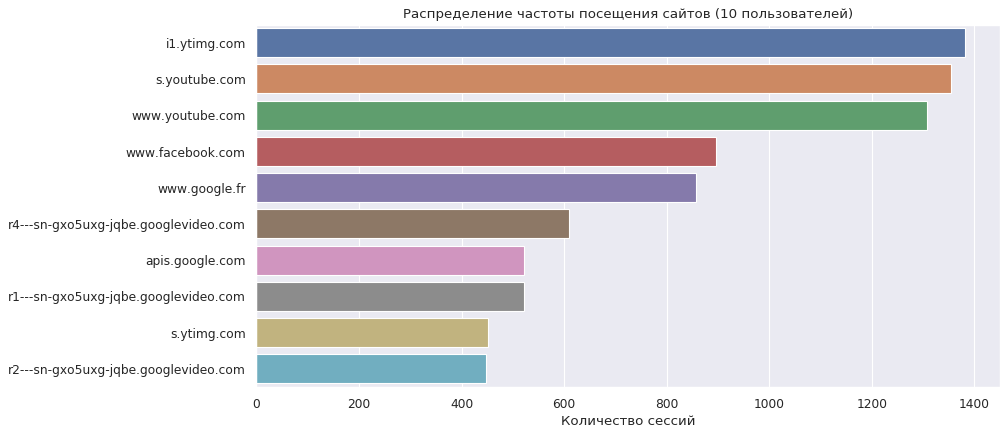

In [45]:
plt.figure(figsize=(12, 6), dpi=80)
ax = sns.barplot(top_sites_1.values[:10], 
                 top_sites_1.index[:10], orient='h')
ax.set_title('Распределение частоты посещения сайтов (10 пользователей)')
ax.set_xlabel('Количество сессий')

## Топ-10 для других пользователей

Text(0.5, 0, 'Количество сессий')

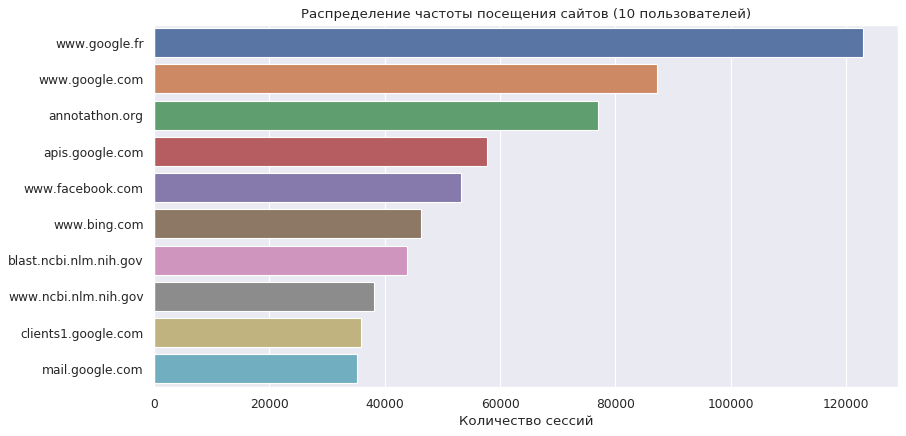

In [46]:
plt.figure(figsize=(12, 6), dpi=80)
ax = sns.barplot(top_sites_0.drop('unknown').values[:10], 
                 top_sites_0.drop('unknown').index[:10], orient='h')
ax.set_title('Распределение частоты посещения сайтов (10 пользователей)')
ax.set_xlabel('Количество сессий')

### Предположения

Можно отметить, что:
- пользователи не начинают сессии по ночам (после 23.00 до 7.00),
- все сессии длятся меньше 3-4 минут,
- почти все пользователи начинают сессии в дневное время.
- распределения выхода по дням - различные,
- основные посещаемые сайты: `google, facebook, bing`

**Алиса**:
- характерно посещение сайтов в определенные часы,
- "настоящих" сессий около 40 (видно по дням месяца),
- основные посещаемые сайты: `ytimg, youtube, facebook`

## Обучение модели и кросс-валидация

На основании полученных данных проведем оценку и кросс-валидацию.

In [47]:
import eli5

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from IPython.display import display_html

SEED = 17

def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    sites = ['site%s' % i for i in range(1, 11)]
    
    # IT IS IMPORTANT PART OF CV !
    train_df = fix_incorrect_date_formats(train_df, times)
    test_df = fix_incorrect_date_formats(test_df, times)
 
    train_df[sites] = train_df[sites].fillna(0).astype(int).apply(lambda x: x.map(id2site))
    test_df[sites] = test_df[sites].fillna(0).astype(int).apply(lambda x: x.map(id2site))
    
    train_df[sites] = train_df[sites].applymap(lambda site: re.sub("^\S*?\.*?www\S*?\.", '', site)) 
    test_df[sites] = test_df[sites].applymap(lambda site: re.sub("^\S*?\.*?www\S*?\.", '', site))
    
    train_sessions = train_df[sites].apply(lambda row:' '.join([i for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].apply(lambda row:' '.join([i for i in row]), axis=1).tolist()

    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    return X_train, X_test, y_train, vectorizer, train_times, test_times


def fix_train(x, times):
    month_lt12 = (x['time1'].dt.month < 11) & (x['time1'].dt.year == 2013)
    month_idx = month_lt12[month_lt12].index.values
    month_tft = month_lt12.values
    array_len = month_tft.sum()

    for tx in times:
        np_time = np.c_[
            x[month_tft][tx].dt.month.values, 
            x[month_tft][tx].dt.day.values, 
            x[month_tft][tx].dt.hour.values, 
            x[month_tft][tx].dt.minute.values,
            x[month_tft][tx].dt.second.values
        ]
        np_time = np.c_[[2013]*array_len, [12]*array_len, np_time[:, 0], np_time[:, 2:]].astype(int)
        pd_fix = [pd.Timestamp('') if el[-1] < 0 else pd.Timestamp(*el) for el in np_time]
        x.loc[month_idx, tx] = pd.Series(pd_fix, index=month_idx)


def fix_test(x, times, is_days=True):
    month_gt5 = x['time1'].dt.month > 5
    month_idx = month_gt5[month_gt5].index.values
    month_tft = month_gt5.values
    array_len = month_tft.sum()

    for tx in times:
        np_time = np.c_[
            x[month_tft][tx].dt.month.values, 
            x[month_tft][tx].dt.day.values, 
            x[month_tft][tx].dt.hour.values, 
            x[month_tft][tx].dt.minute.values,
            x[month_tft][tx].dt.second.values
        ]
        
        if is_days:
            np_time = np.c_[np_time[:, 1], np_time[:, 0],  np_time[:, 2:]]
        else:
            np_time = np.c_[[5]*array_len, np_time[:, 0],  np_time[:, 2:]]

        np_time = np.c_[[2014]*array_len, np_time].astype(int)
        pd_fix = [pd.Timestamp('') if el[-1] < 0 else pd.Timestamp(*el) for el in np_time]

    x.loc[month_idx, tx] = pd.Series(pd_fix, index=month_idx)
    
def fix_incorrect_date_formats(df, columns_to_fix):
    ndf = df.copy()
    for time in columns_to_fix:
        d = ndf[time]
        d_fix = d[d.dt.day <= 12]
        d_fix = pd.to_datetime(d_fix.apply(str), format='%Y-%d-%m %H:%M:%S')
        ndf.loc[d_fix.index.values, time] = d_fix
    return ndf

In [48]:
from scipy.sparse import hstack

### Подготовка данных

In [49]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 6),
                       'max_features': 200000,
                       'tokenizer': lambda s: s.split()
                      }
)

CPU times: user 58.1 s, sys: 973 ms, total: 59.1 s
Wall time: 59.1 s


**Для данных, представленных в виде сайтов применим TF-IDF Vectorizer (или CountVectorizer) вместо создания разреженной матрицы. Это позволит повысить Public Score на Kaggle.**

In [50]:
vectorizer.get_feature_names()[:20]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com plus.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com translate.google.fr',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com translate.google.fr 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com translate.google.fr 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.

**Поскольку данные распределены во времени - используем `TimeSeriesSplit`. Количество разбиений - 10.**

Пример для 5 разбиений:
```
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]
```

In [51]:
time_split = TimeSeriesSplit(n_splits=10)
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [52]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

**Первичный анализ (временные признаки отсутствуют)**

In [53]:
cv_scores1 = train_and_predict(model=logit, 
                               X_train=X_train_sites, 
                               y_train=y_train, 
                               X_test=X_test_sites, 
                               site_feature_names=vectorizer.get_feature_names(),
                               cv=time_split, 
                               submission_file_name='kaggle_subm1.csv'
                              )

CV scores [0.80414577 0.65831809 0.86230414 0.93198732 0.83651335 0.88944048
 0.877462   0.88202585 0.91580546 0.92241572]
CV mean: 0.8580418195082178, CV std: 0.07626455583980385


Weight?,Feature
+6.112,youwatch.org
+5.996,vk.com
+5.290,fr.glee.wikia.com
+5.031,info-jeunes.net
+4.836,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.620,audienceinsights.net
+4.439,melty.fr
+4.395,i1.ytimg.com
+4.347,video.tt
+4.338,banque-chalus.fr


**Добавление временных признаков**

In [54]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night]
    
    feature_names = ['morning', 'day', 'evening', 'night']
#     objects_to_hstack = [X_sparse, alice0, alice1, alice2]
#     feature_names = ['alice0', 'alice1', 'alice2']
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [55]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=True)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites, add_hour=True)

CPU times: user 2.68 s, sys: 19.9 ms, total: 2.7 s
Wall time: 2.7 s


In [56]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='kaggle_subm2.csv')

CV scores [0.81043392 0.78793316 0.94817046 0.96746559 0.88217304 0.96719413
 0.91243035 0.93974262 0.96474418 0.96755161]
CV mean: 0.9147839038715141, CV std: 0.06370972197616652


Weight?,Feature
+7.043,hour
+5.472,vk.com
+5.152,express.co.uk
+5.005,youwatch.org
+4.965,info-jeunes.net
+4.914,melty.fr
+4.626,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.431,audienceinsights.net
+4.401,fr.glee.wikia.com
+4.161,i1.ytimg.com


New feature weights:
   feature      coef
0  morning -2.849939
1      day -0.580617
2  evening -5.062423
3    night  0.000000
4     hour  7.042881


In [57]:
%%time
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)

CPU times: user 2.35 s, sys: 29.1 ms, total: 2.37 s
Wall time: 2.37 s


In [58]:
cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train, 
                               X_test=X_test_with_times2, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='kaggle_subm3.csv')

CV scores [0.86701054 0.81148986 0.92138132 0.96324953 0.91061257 0.95191853
 0.92277945 0.94172912 0.94490525 0.95026379]
CV mean: 0.9185339964856023, CV std: 0.04422243465936644


Weight?,Feature
+5.690,vk.com
+5.379,youwatch.org
+5.117,express.co.uk
+4.727,melty.fr
+4.721,fr.glee.wikia.com
+4.692,info-jeunes.net
+4.589,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.569,audienceinsights.net
+4.261,i1.ytimg.com
+3.955,banque-chalus.fr


New feature weights:
   feature      coef
0  morning -3.156780
1      day  0.560381
2  evening -2.710638
3    night  0.000000


**Добавление дней недели и других признаков**

- Длина сессии (вещественный признак требуется масштрабировать через StandardScaler)
- День недели (категориальный признак требуется преобразовать через OneHotEncoder)

In [59]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[s]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[s]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

def add_day_month(times, X_sparse):
    day_of_week = times['time1'].dt.weekday.values.reshape(-1, 1)

    dummy_days = pd.get_dummies(day_of_week.flatten())

    objects_to_hstack = [X_sparse, dummy_days]
    feature_names = ['day_of_weeks']
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [60]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

X_train_final, more_feat_names = add_day_month(train_times, X_train_with_times2)
X_test_final, _ = add_day_month(test_times, X_test_with_times2)

In [61]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               #new_feature_names=new_feat_names + more_feat_names,
                               cv=time_split, submission_file_name='kaggle_subm4.csv')

CV scores [0.85206838 0.81620326 0.92263378 0.96321263 0.91151031 0.95357708
 0.92523743 0.9429805  0.94685892 0.95050973]
CV mean: 0.9184792013090324, CV std: 0.04543884056946067


Weight?,Feature
+5.794,vk.com
+5.365,youwatch.org
+5.113,express.co.uk
+4.706,melty.fr
+4.695,fr.glee.wikia.com
+4.681,info-jeunes.net
+4.557,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.520,audienceinsights.net
+4.220,i1.ytimg.com
+4.002,banque-chalus.fr


New feature weights:
         feature      coef
0        morning -3.178706
1            day  0.540210
2        evening -2.711205
3          night  0.000000
4  sess_duration -0.268373


**Проверка полученных решений**

- На первом шаге сравним полученные значения по каждому "фолду":

Принцип: если большая часть данных превосходит предыдущее решение -то все ОК, можно двигаться дальше.

In [62]:
cv_scores4 > cv_scores3

array([False,  True,  True, False,  True,  True,  True,  True,  True,
        True])

In [63]:
cv_scores3 > cv_scores2

array([ True,  True, False, False,  True, False,  True,  True, False,
       False])

In [64]:
cv_scores2 > cv_scores1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [65]:
cv_scores1

array([0.80414577, 0.65831809, 0.86230414, 0.93198732, 0.83651335,
       0.88944048, 0.877462  , 0.88202585, 0.91580546, 0.92241572])

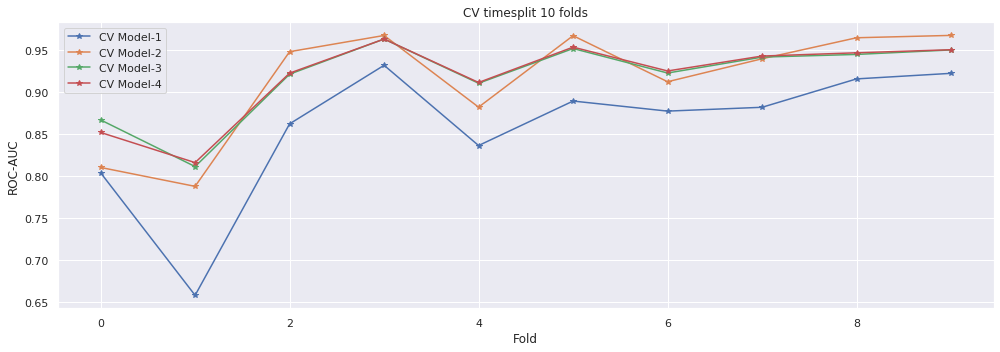

In [66]:
plt.figure('CV Plot', figsize=(14, 5))
plt.title('CV timesplit 10 folds')
plt.plot(cv_scores1, '-*', label='CV Model-1')
plt.plot(cv_scores2, '-*', label='CV Model-2')
plt.plot(cv_scores3, '-*', label='CV Model-3')
plt.plot(cv_scores4, '-*', label='CV Model-4')
plt.legend(loc='best')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC')
plt.tight_layout()

### Подбор гиперпараметров

Для последней модели подберём **гиперпараметры** для Логистической регрессии.

- `C` - обратная величина коэффициента мощности регуляризации. Положительное вещественное число. Чем меньше значение, тем сильнее регуляризация. 
- `max_iter` - положительное целочисленное число. Максимальное число итераций для решателя модели.

In [67]:
# %%time
param_grid = {
    'C' : np.logspace(-1, 2, 20),
    'solver' : ['liblinear'],
    'max_iter' : [50]
}

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid=param_grid,
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

logit_grid_searcher.fit(X_train_with_time_correct, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='wa...
             param_grid={'C': array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59

### Итоговая модель

Выведем следующие характеристики:
- Лучшие параметры,
- Лучшие показатели

In [68]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9258253659414201,
 {'C': 5.455594781168517, 'max_iter': 50, 'solver': 'liblinear'})

In [69]:
final_model = logit_grid_searcher.best_estimator_

In [70]:
cv_scores5 = train_and_predict(model=final_model, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm7.csv')

CV scores [0.88215088 0.81078699 0.935096   0.97164257 0.91544818 0.95153015
 0.94693138 0.93988505 0.9545902  0.95016064]
CV mean: 0.9258222052263468, CV std: 0.04489725145643686


Weight?,Feature
+10.849,cid-ed6c3e6a5c6608a4.users.storage.live.com
+10.415,express.co.uk
+8.969,activistpost.com
+7.274,fr.glee.wikia.com
+6.961,vk.com
+6.901,monalbumphoto.fr
+6.617,tru.am
+6.616,banque-chalus.fr
+6.429,video.tt
+6.377,cid-4390f92c7906cc9c.users.storage.live.com


New feature weights:
         feature      coef
0        morning -3.236826
1            day  0.654285
2        evening -3.719095
3          night  0.000000
4  sess_duration -0.182979


Text(0, 0.5, 'Std Score')

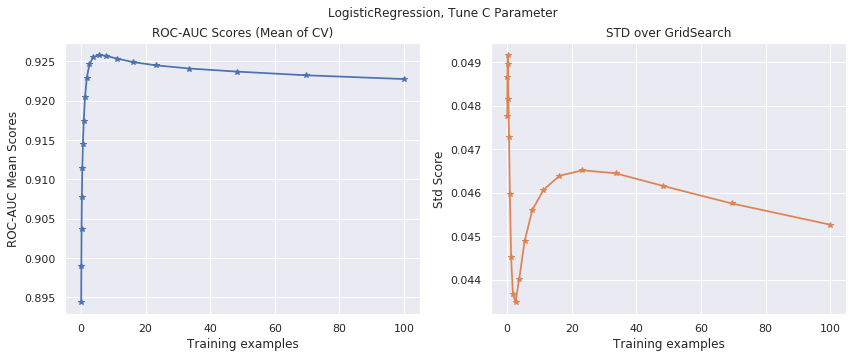

In [71]:
x = logit_grid_searcher.cv_results_['param_C'].data
y = logit_grid_searcher.cv_results_['mean_test_score']
z = logit_grid_searcher.cv_results_['std_test_score']

plt.figure('CV Plot', figsize=(14, 5))
plt.suptitle('LogisticRegression, Tune C Parameter')

plt.subplot(1,2,1)
plt.plot(x, y, '-*', linewidth=1.75, color='C0')
plt.title('ROC-AUC Scores (Mean of CV)')
plt.xlabel('Training examples')
plt.ylabel('ROC-AUC Mean Scores')

plt.subplot(1,2,2)
plt.plot(x, z, '-*', linewidth=1.75, color='C1')
plt.title('STD over GridSearch')
plt.xlabel('Training examples')
plt.ylabel('Std Score')

**Как видно из полученных выше графиков - среднее значение ROC-AUC по 10 разбиениям имеет глобальный максимум, в то время как дисперсия имеет нелинейную зависимость, но также имеет глобальный минимум**

Критерий выбора гиперпараметров:

- Минимизация дисперсии,
- Максимизация среднего значения.

In [72]:
logit_grid_searcher.best_params_

{'C': 5.455594781168517, 'max_iter': 50, 'solver': 'liblinear'}

In [ ]:
#learning_curve?

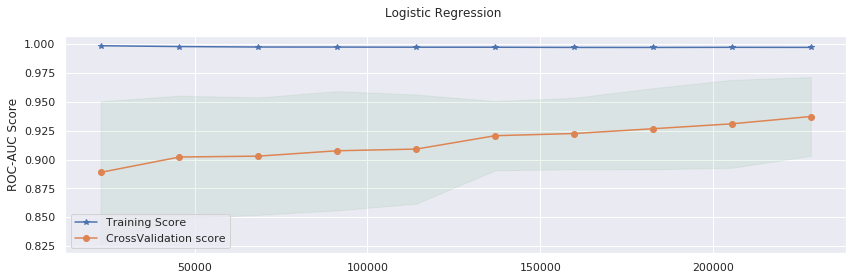

In [73]:
from sklearn.model_selection import learning_curve, validation_curve

parts = np.linspace(.1, 1.0, 10)
plt.figure('CV Plot', figsize=(14, 4))
plt.suptitle('Logistic Regression')
plt.ylabel('ROC-AUC Score')

train_sizes, train_scores, test_scores = learning_curve(
    final_model, 
    X_train_with_time_correct, 
    y_train, 
    cv=10, 
    n_jobs=-1,
    train_sizes=parts,
    scoring='roc_auc'
)

train_cv_mean = np.mean(train_scores, axis=1)
train_cv_std = np.std(train_scores, axis=1)
test_cv_mean = np.mean(test_scores, axis=1)
test_cv_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, test_cv_mean - test_cv_std,
                 test_cv_mean + test_cv_std, alpha=0.1, color='C2')
plt.plot(train_sizes, train_cv_mean, '*-', color='C0', label="Training Score")
plt.plot(train_sizes, test_cv_mean, 'o-', color='C1', label="CrossValidation score")
plt.grid(True)
plt.legend(loc='best')

# Выводы

В данной работе решалась задача по **идентификации отдельного пользователя** (Алиса). Задача решалась с использованием набора данных о посещении пользователями Интернета в различные временные промежутки и отдельные даты. Для удобства данные были объединены в короткие сессии по 30 минут. В каждой сессии - до 10 записей включительно.


## Применение в бизнес-задачах:

- **Таргетинг**: зная о посещениях пользователем определенных сайтов или последовательностей сайтов можно сделать предположения о его вкусах, интересах. На основании этой информации можно давать **рекомендации** и показывать ту или иную рекламу. Одно из применений: повышение конверсии "кликов" в "покупки" для интернет-магазинов.
- **Кластеризация**: разделение пользователей на группы и подгруппы для сайтов типа "форумы" или "сайты знакомств". Позволяет находить группы по интересам, предлагать те или иные знакомства среди всех пользователей.
- **Предсказание атак**: зная о поведении пользователя в сети и обнаружив его "странную" активность, можно предположить, что в определенное время не он пользуется сервисом. Это поможет идентифицировать мошенников и злоумышленников. Полезное применение - банки, сайты с персональными данными (госуслуги, мос.ру, почта и т.д.).
- **Подтверждение активности**: смежная к предыдущему пункту задача. Если пользователь начал активно применять гаджеты, которые раньше не использовал, алгоритм может помочь понять его "необычную активность", предложив ввести капчу или пройти дополнительную проверку идентификации и аутентификации.


## Проект (закономерности, "инсайты")

В данном отчёте по большей части представлена задача поиска особенностей для соревнования Kaggle **Catch Me If You Can**. 

**Выявлен ряд особенностей**:
- Предложенные в Kernel-ах схемы Кросс-валидации работали некорректно и приводили с расхождению результатов скоринга на локальном примере и на Public Leader Board на странице соревнования.
- Изначально данные содержали **ошибку парсера дат**: месяц и день были спутаны местами.
- Исправление ошибки привело к положительной корреляции результатов соревнования.
- Проведен глобальный анализ временных признаков: 
   * **Час**: распределения отличаются для Алисы и других пользователей. Информативный признак, вносящий наибольший вклад в полученный результат. В то же время этот признак приводит к переобучению.
   * **Месяц**: менее информативный признак, но зная распределение активности в течение месяца - можно выжать дополнительные улучшения
   * **День недели**: информативный признак. Известно, что Алиса не выходила в интернет в последние два дня недели. 
   * **День месяца**: в совокупности с месяцем дает небольшой прирост показателей.
   * **Год**: бесполезный неинформативный признак
   * **Продолжительность сессии**: для пользователей характерны короткие сессии по 3-5 минут. 
   * **ТОП-10 сайтов**: для Алисы и остальных пользователей топ-10 сайтов различаются.
- Используются дополнительные методы улучшения модели:
   * **StandardScaler** для вещественных признаков (длина сессии),
   * **OneHotEncoder** для категориальных признаков (день недели, месяц и т.д.).
- Для таблицы сайтов:
   * Использованы три способа разбиения: **Sparse Matrix, Count Vectorizer, TF-IDF Vectorizer**.
   * Опытным путём установлено, что **TF-IDF Vectorizer** даёт наилучший результат.
- Использована метрика ROC-AUC для несбалансированной выборки. 
- Балансировка выборки с помощью **Oversampling / Undersampling** не приводит к улучшению результата, а в большинстве случев даже ухудшает его.
- Проведен подбор гиперпараметров единственной модели `LogisticRegression`,
- **Не используется блендинг, стакинг и бустинг**. Достигнуты высокие показатели на использовании только линейной модели.

После создания оригинальных признаков было проведено тестирование модели. Итоговая модель - `LogisticRegression` с настроенными гиперпараметрами. `ROC AUC score` **для соревнования Kaggle - `0.96068`. Место - `119` из `3752` по состоянию на 10 декабря 2019 года**. 


## Пути улучшения

- Добавление дополнительных уникальных признаков,
- Исследование модели с "окном" длительности сессии > 10,
- Применение других алгоритмов и их сочетаний - kNN, SVM, RF и т.д.,
- Стекинг, бустинг, блендинг.

___